### SAD Score Distribution

Author: Sophie Sigfstead

Purpose of the notebook: Currently I am working to design a better thresholding mechanism for our SNP activity difference scores. One method proposed is to use FDR to include / disclude SNPs based on whether or not we reject the null hypothesis of mean(SAD_values) for <snp_j> = 0. 

As such, I'm doing some simple visualizations here to see how the sad values are distributed. 

In [20]:
import pandas as pd
import os
from tqdm import tqdm

# Define the directory containing the CSV files
csv_directory = "../GWAS_Data/1000genomes_as_csv"

# Create an empty DataFrame to hold the combined SAD values
combined_df = pd.DataFrame()

# Define the maximum number of rows
max_rows = 5_000_000

# Loop through all CSV files in the directory
for file_name in (os.listdir(csv_directory)):
    if file_name.endswith(".csv"):  # Ensure the file is a CSV
        file_path = os.path.join(csv_directory, file_name)
        
        # Read the CSV file in chunks to handle large file sizes
        chunk_size = 10**6  # Adjust chunk size as needed
        for chunk in pd.read_csv(file_path, chunksize=chunk_size):
            # Extract all columns starting with "SAD"
            sad_columns = [col for col in chunk.columns if col.startswith("SAD")]
            sad_chunk = chunk[sad_columns]
            
            # Append the SAD columns to the combined DataFrame
            combined_df = pd.concat([combined_df, sad_chunk], ignore_index=True)
            # Break the outer loop if the maximum row limit is reached
            if len(combined_df) >= max_rows:
                break
            
    # Break the outer loop if the maximum row limit is reached
    if len(combined_df) >= max_rows:
        break    # Break the outer loop if the maximum row limit is reached
       

# Save the combined DataFrame to a CSV file
combined_df.to_csv("combined_sad_values.csv", index=False)

# Display the first few rows of the combined DataFrame
print(combined_df.head())



KeyboardInterrupt: 

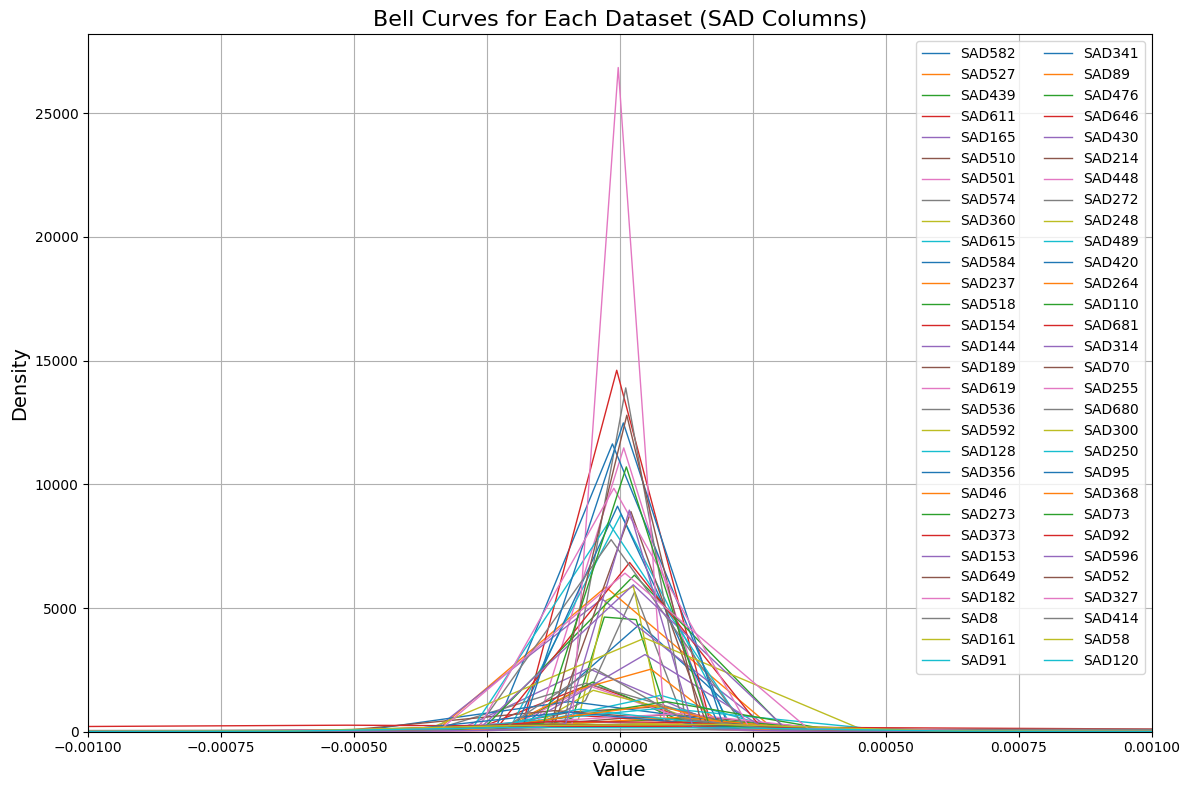

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random 

# Assuming `df` contains the data with columns SAD0, SAD1, ..., SAD683
columns_to_plot = [col for col in combined_df.columns if col.startswith("SAD")]
columns_to_plot = random.sample(columns_to_plot, 60)
combined_df = combined_df[0:1000000]

# Set up the plot
plt.figure(figsize=(12, 8))

# Plot each column as a KDE (Kernel Density Estimate) plot
for column in columns_to_plot:
    sns.kdeplot(combined_df[column], label=column, linewidth=1)

# Add labels and legend
plt.title("Density Curves for Each Dataset (SAD Columns)", fontsize=16)
plt.xlabel("Value", fontsize=14)
plt.xlim(-0.001, 0.001)
plt.ylabel("Density", fontsize=14)
plt.legend(loc='upper right', fontsize=10, ncol=2)  # Adjust legend placement and size
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp

# Number of samples to generate
total_samples = 10000
sample_size = 33

# storage for results
results = []


for _ in range(total_samples):
    # randomly select a row
    random_row = combined_df.sample(n=1, axis=0).iloc[0]
    
    # sample 33 SAD values from the row
    sample = random_row.sample(n=sample_size, replace=False)
    
    # perform a one sample t-test; Null hypothesis u = 0
    t_stat, p_value = ttest_1samp(sample, popmean=0)
    
    # store results
    results.append({
        "sample_mean": sample.mean(),
        "t_stat": t_stat,
        "p_value": p_value
    })


results_df = pd.DataFrame(results)

results_df.head()

,sample_mean,t_stat,p_value
0,-8.769697e-07,-1.009580,0.320270
1,-1.660606e-06,-0.966881,0.340855
2,-2.072212e-04,-2.861589,0.007371
3,2.397818e-05,3.671407,0.000873
4,1.548030e-05,4.150893,0.000229


In [15]:
# Summary of hypothesis testing
print("Summary of hypothesis testing:")
print(results_df.describe()) 

Summary of hypothesis testing:
        sample_mean        t_stat       p_value
count  1.000000e+04  10000.000000  1.000000e+04
mean  -1.389126e-06      0.013913  2.195351e-01
std    1.847523e-04      2.935275  2.789683e-01
min   -4.057152e-03    -16.725608  2.236801e-17
25%   -1.478432e-05     -1.790475  4.713517e-03
50%    1.316667e-07      0.024249  8.051439e-02
75%    1.565576e-05      1.823986  3.570436e-01
max    3.917318e-03     16.091305  9.999300e-01


In [25]:
len(results_df[results_df['p_value'] < 0.005])/10000

0.2535

Previously, ~25-30% of SNPs were included in the GWAS (filtered) so it may be alpha = 0.005 is a good option, but different alpha values can be tested. 